In this notebook, we take two beams that hit the structure at two incident angles, and infer their phase difference from merely intensity measurement under a few twist angle variations.

The PhCs will all have same geometric parameters: circular through holes in dielectric slab, arranged in sqare lattice.

Everything is in normalized units: length in units of a (period), frequency in c/a.

In [1]:
from rcwa4d import *
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

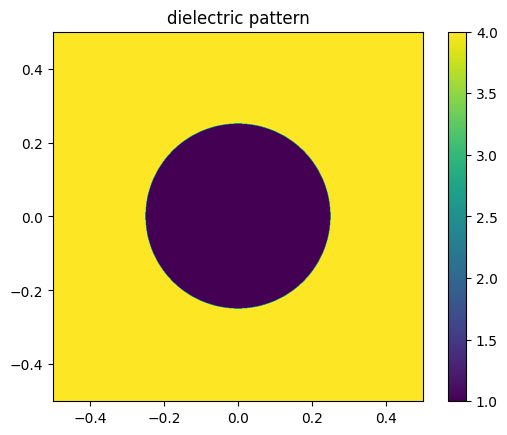

In [2]:
### some params
DEG = np.pi/180
Ny=Nx=1000 ### resolution for dielectric pattern
eps = np.ones([Ny,Nx])*4 ### uniform dielectric slab
radius = 0.25
thickness = 0.2
xs,ys = np.linspace(-0.5,0.5,Nx), np.linspace(-0.5,0.5,Ny)
xs,ys = np.meshgrid(xs,ys)
eps[xs**2 + ys**2 < radius**2] = 1 ### air holes in dielectric slab
plt.imshow(eps,extent=[-0.5,0.5,-0.5,0.5]); plt.colorbar(); plt.title('dielectric pattern'); plt.show()
### size of truncation of reciprocal lattice:
ind = 2
NM = (2*ind+1)**2
NMNM = NM**2
### frequencies to scan through:
freqs = np.linspace(0.7,0.84,141)
twists = np.linspace(0,45,46) * DEG

In [3]:
### specify two orders for target beam and reference beam to be incident onto structure
inc1 = NM*NM//2 - (NM-1)
inc2 = NM*NM//2 + (NM-1)
inc1,inc2

(288, 336)

In [11]:
# twists = np.linspace(10*DEG,20*DEG,11)
twists = np.linspace(11*DEG,14*DEG,31)
# twists = np.linspace(1*DEG,45*DEG,45)
phases = np.linspace(0,np.pi,11)

try:
    trans = np.load('example2-trans-twist-phase.pkl',allow_pickle=True)
except Exception as e:
    print(e)
    ref = []
    trans = []
    kxkys = []
    for twist in tqdm(twists):
        obj = rcwa([eps,None,eps], [thickness,thickness,thickness], [1,1,2], gap_layer_indices=[1], twist=twist, N=ind, M=ind, verbose=0)
        obj.set_freq_k(freqs[0], (0, 0))
        for phase in phases:
            cinc = np.zeros(NM*NM*2,dtype=complex)
            cinc[inc1]=0.707
            cinc[inc2]=0.707 * np.exp(phase * 1j)
            (r,t), (reflected,transmitted) = obj.get_RT(0,1,cinc_overwrite=cinc)
            ref.append(r)
            trans.append(t)
    trans = np.array(trans).reshape(len(twists),len(phases))
    trans.dump('example2-trans-twist-phase.pkl')

Text(0.5, 1.0, 'Transmission vs twist and phase')

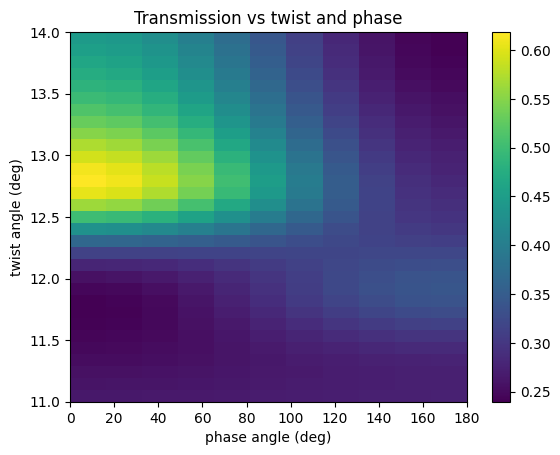

In [12]:
plt.imshow(trans,extent=[phases[0]/DEG,phases[-1]/DEG,twists[0]/DEG,twists[-1]/DEG],origin='lower',aspect='auto')
plt.colorbar()
plt.xlabel('phase angle (deg)')
plt.ylabel('twist angle (deg)')
plt.title('Transmission vs twist and phase')

Text(0.5, 1.0, 'Twist-dependent transmissions for various phase angles')

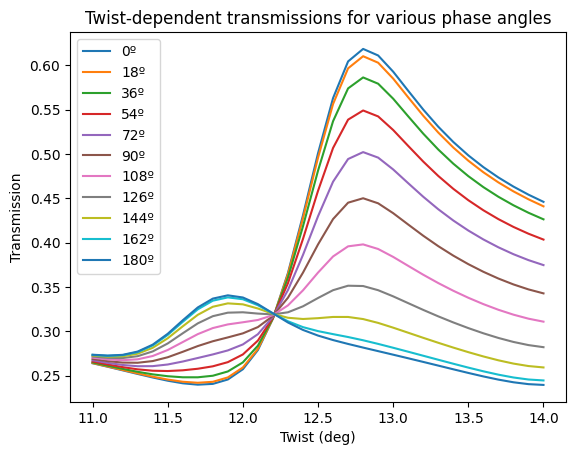

In [13]:
plt.plot(twists/DEG, trans)
plt.legend([f'{i/DEG:.0f}º' for i in phases])
plt.xlabel('Twist (deg)')
plt.ylabel('Transmission')
plt.title('Twist-dependent transmissions for various phase angles')

# Now see how well it helps recovery

Compressed sensing requires restricted isometry properties, which could be a metric to evaluate how good our bases are. But a more direct way is to vary noise and see when performance breaks down.

Here we assume multiplicative noise, which is the main type in our experiment (with an alternative being additive noise).

We keep using all twist angles (without any adaptive algo), and take true signal to be a delta peak, so the optimal recovery is just to pick a phase that maximizes the likelihood of the observations.

In [25]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

pca = PCA(n_components=3)
pca.fit(np.hstack([X,X]))
print('# twists', len(twists))
print('# phases', len(phases))


# twists 31
# phases 11


In [27]:
print(pca.explained_variance_ratio_)

[9.92442890e-01 7.55710991e-03 4.99800485e-34]


In [28]:
pca.singular_values_

array([8.91041139e+00, 7.77540219e-01, 1.99960093e-16])

In [31]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 3,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [33]:
pca.inverse_transform(np.array([1,0,0]))

array([-0.59290355, -0.38531206, -0.59290355, -0.38531206])